In [1]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from mmon_gcm.analysing import get_phase_lengths
from mmon_gcm.supermodel import SuperModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()
sns.set_style("ticks")
palettes = {
    "tol_bright": sns.color_palette(
        ["#4477AA", "#66CCEE", "#228833", "#CCBB44", "#EE6677", "#AA3377", "#BBBBBB"]
    ),
    "tol_muted": sns.color_palette(
        [
            "#332288",
            "#88CCEE",
            "#44AA99",
            "#117733",
            "#999933",
            "#DDCC77",
            "#CC6677",
            "#882255",
            "#AA4499",
        ]
    ),
}
sns.set_palette(palettes["tol_muted"])

colours = sns.color_palette()

params = {
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "x-large",
    "font.family": "sans-serif",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
    "savefig.bbox": "tight",
    "lines.linewidth": 2.5,
    "figure.figsize": [5, 3.75],
    "figure.dpi": 150,
}
plt.rcParams.update(params)

In [4]:
def get_bounds_in_model(constraints):
    super_model = SuperModel(constraints)
    volumes = super_model.get_volumes(per_guard_cell=False)
    closed_volume = volumes[0]
    open_volume = volumes[1]
    osmolarities = super_model.get_osmolarities()
    closed_osmolarity = osmolarities[0]
    open_osmolarity = osmolarities[1]
    photons = super_model.get_photons(150)
    gc_photons = photons[0]
    gc_atpase_upper_bound = super_model.get_atpase_constraint_value(
        constraints.loc["ATPase"]
    )

    return {
        "V_closed": closed_volume,
        "V_open": open_volume,
        "Os_closed": closed_osmolarity,
        "Os_open": open_osmolarity,
        "Photons": gc_photons,
        "ATPase": gc_atpase_upper_bound,
    }

# Analysing the results of the constraint scan

## Importing results and constraints

In [5]:
# import results files
blue_results = pd.read_csv(
    "../outputs/constraint_scan/constraint_scan_results_blue.csv", index_col=0
)
white_results = pd.read_csv(
    "../outputs/constraint_scan/constraint_scan_results_white.csv", index_col=0
)
scan_results = pd.concat([white_results, blue_results])
scan_results = scan_results.reset_index().drop("index", axis=1)
# remove solutions which were not feasible
infeasible_solutions = scan_results[scan_results.isna().any(axis=1)]
feasible_solutions = scan_results.dropna()
scan_results = feasible_solutions

In [6]:
len(infeasible_solutions)

1

In [7]:
len(feasible_solutions)

1929

In [8]:
scan_results.shape

(1929, 7097)

In [9]:
# convert any fluxes that are below 10^-6 to 0
scan_results = scan_results.mask(abs(scan_results) < 0.000001, other=0)

In [10]:
# import constraints files
white_constraints = pd.read_csv(
    "../outputs/constraint_scan/constraints_df.csv", index_col=0
)
white_constraints["light"] = "white"
blue_constraints = pd.read_csv(
    "../outputs/constraint_scan/constraints_df.csv", index_col=0
)
blue_constraints["light"] = "blue"
scan_constraints = pd.concat([white_constraints, blue_constraints])
scan_constraints = scan_constraints.reset_index().drop("index", axis=1)
# remove infeasible constraints combinations
feasible_scan_constraints = scan_constraints.loc[feasible_solutions.index]
infeasible_scan_constraints = scan_constraints.loc[infeasible_solutions.index]
scan_constraints = feasible_scan_constraints

# Remove maintenance in scan_constraints
scan_constraints = scan_constraints.drop('Maintenance', axis=1)

In [11]:
scan_constraints.columns

Index(['P_abs', 'T_l', 'A_l', 'V_gc_ind', 'FqFm', 'R_ch', 'R_ch_vol', 'L_air',
       'L_epidermis', 'Vac_frac', 'T', 'R', 'N_gcs', 'n', 'm', 'r', 's',
       'C_apo', 'A_closed', 'A_open', 'ATPase', 'light'],
      dtype='object')

In [12]:
# import constraints that were used in previous paper solutions
default_constraints = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)[
    "Value"
]

paper_constraints = []
index = []
for light in ["white", "blue", "nops"]:
    for constraint in ["unconstrained", "constrained"]:
        constraints = default_constraints.copy()
        if constraint == "unconstrained":
            constraints["ATPase"] = 1000
        elif constraint == "constrained":
            constraints["ATPase"] = 7.48
        constraints["light"] = light
        index.append(f"{light}_{constraint}_wt")
        paper_constraints.append(constraints)
paper_constraints = pd.DataFrame(paper_constraints, index=index)
paper_constraints = paper_constraints.iloc[1, :-1]
paper_constraints

P_abs                  0.9
T_l                0.00017
A_l                    1.0
V_gc_ind               0.0
FqFm                   0.9
R_ch              0.069231
R_ch_vol          0.200476
L_air                 0.37
L_epidermis           0.15
Vac_frac             0.751
T                   296.15
R                  0.08205
N_gcs          580000000.0
n                      2.5
m                      0.8
r                      0.0
s                      0.0
C_apo              0.02302
A_closed               1.6
A_open                2.75
ATPase                7.48
Name: white_constrained_wt, dtype: object

In [13]:
# import results for previous simulations in paper
paper_solution_files = []

for light in ["white", "blue", "nops"]:
    for constraint in ["unconstrained", "constrained"]:
        paper_solution_files.append(f"{light}_{constraint}_wt.csv")
solution_dfs = [
    pd.read_csv(f"../outputs/model_solutions/{file_name}", index_col=0)["fluxes"]
    for file_name in paper_solution_files
]
paper_results = pd.concat(solution_dfs, axis=1).T
paper_results.index = index

In [14]:
# get a reduced get of constraints that are more specific to the guard cell

scan_gc_constraints = pd.DataFrame.from_dict(
    list(scan_constraints.apply(get_bounds_in_model, axis=1))
)
scan_gc_constraints["Os_dif"] = (
    scan_gc_constraints["Os_open"] - scan_gc_constraints["Os_closed"]
)
scan_gc_constraints.index = scan_constraints.index
scan_gc_constraints.head()

/home/maurice/Sync/GC/mmon-gcm/mmon_gcm/supermodel.py:23: UserWarning: No fba model added to the Supermodel, fine if that's what you want
  warnings.warn("No fba model added to the Supermodel, fine if that's what you want")


,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
0,0.000085,0.000126,0.018035,0.041323,0.045613,0.002164,0.023288
1,0.000319,0.000671,0.077930,0.350492,0.418305,0.004629,0.272562
2,0.000203,0.000376,0.040124,0.126824,0.343557,0.000851,0.086700
3,0.000205,0.000290,0.033918,0.068658,0.096408,0.005861,0.034740
4,0.000247,0.000483,0.060282,0.272076,0.217660,0.006976,0.211795


In [15]:
paper_gc_constraints = pd.Series(get_bounds_in_model(paper_constraints))
paper_gc_constraints["Os_dif"] = (
    paper_gc_constraints["Os_open"] - paper_gc_constraints["Os_closed"]
)
paper_gc_constraints

/home/maurice/Sync/GC/mmon-gcm/mmon_gcm/supermodel.py:23: UserWarning: No fba model added to the Supermodel, fine if that's what you want
  warnings.warn("No fba model added to the Supermodel, fine if that's what you want")


V_closed     0.000220
V_open       0.000254
Os_closed    0.039359
Os_open      0.054922
Photons      0.018372
ATPase       0.004338
Os_dif       0.015563
dtype: float64

## 7a - What contributes to phloem output?

### Set up features for linear regression by 

#### Convert light using onehotencoder

In [16]:
scan_constraints[["light"]]

,light
0,white
1,white
2,white
3,white
4,white
...,...
1925,blue
1926,blue
1927,blue
1928,blue


In [17]:
# extract the subject column as a pandas DataFrame
light = scan_constraints[["light"]]
# setting sparse=False means that enc.transform() will return an array
enc = OneHotEncoder(sparse_output=False)

# fit the encoder to the data
enc.fit(light)

# encode the data
light_enc = enc.transform(light)
light_columns = pd.DataFrame(light_enc, columns="light_" + enc.categories_[0], index=scan_constraints.index) # Added index=scan_constraints.index 
full_features = scan_constraints.drop("light", axis=1).join(light_columns)
gc_features = scan_gc_constraints.join(light_columns)

#### Also create scaled versions of features

In [18]:
scaler = StandardScaler()

scaler.fit(full_features)
full_features_scaled = scaler.transform(full_features)

scaler.fit(gc_features)
gc_features_scaled = scaler.transform(gc_features)

In [19]:
full_features[full_features.isna().any(axis=1)]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,n,m,r,s,C_apo,A_closed,A_open,ATPase,light_blue,light_white


### Compare full and gc features

In [20]:
response = scan_results.Phloem_tx_overall
#response = scan_results.Photon_tx_gc_3

lm_full = LinearRegression()
lm_full.fit(full_features, response)
full_pred = lm_full.predict(full_features)
print("Mean squared error, MSE = %.5f" % mean_squared_error(response, full_pred))
print("Coefficient of determination, r2 = %.5f" % r2_score(response, full_pred))

lm_gc = LinearRegression()
lm_gc.fit(gc_features, response)
gc_pred = lm_gc.predict(gc_features)
print("Mean squared error, MSE = %.5f" % mean_squared_error(response, gc_pred))
print("Coefficient of determination, r2 = %.5f" % r2_score(response, gc_pred))

Mean squared error, MSE = 0.00040
Coefficient of determination, r2 = 0.99960
Mean squared error, MSE = 0.85721
Coefficient of determination, r2 = 0.14477


So can't predict phloem output using GC features, but can predict pretty well using the full set

#### Which features are most important?

In [21]:
pd.DataFrame(lm_full.coef_, index=full_features.columns).sort_values(by=0)

,0
T_l,-1.317855e+00
light_blue,-3.534076e-01
C_apo,-2.452575e-03
m,-1.637504e-03
R_ch_vol,-4.794674e-04
L_epidermis,-2.945331e-04
A_open,-2.303480e-04
Vac_frac,-1.874333e-04
n,-1.245475e-04
L_air,-9.734578e-06


Lots of unimportant features so we can use lasso regression to see which ones we really need

#### Try different alphas for lasso to see r2

In [22]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.01, 0.1, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features, response)
    lasso_pred = lasso.predict(full_features)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.01    0.962321
0.02    0.850491
0.03    0.664109
0.04    0.403174
0.05    0.115593
0.06    0.110378
0.07    0.105068
0.08    0.098971
0.09    0.092094
0.10    0.084409
dtype: float64

In [23]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.001, 0.01, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features, response)
    lasso_pred = lasso.predict(full_features)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.001    0.999224
0.002    0.998106
0.003    0.996242
0.004    0.993633
0.005    0.990278
0.006    0.986178
0.007    0.981332
0.008    0.975740
0.009    0.969403
0.010    0.962321
dtype: float64

Lets take 0.03 as it's highest that rounds to 0.999

#### Lasso with alpha = 0.003

In [24]:
lasso = Lasso(alpha=0.003)
lasso.fit(full_features, response)
lasso_pred = lasso.predict(full_features)
lass_coefs = pd.DataFrame(lasso.coef_, index=full_features.columns).sort_values(by=0)
# display coefficients that aren't 0
lass_coefs[abs(lass_coefs.loc[:, 0]) > 0.00001]

,0
light_blue,-0.694715
A_closed,-0.000411
T,-0.000215
A_open,-0.000178
ATPase,-0.000061
P_abs,16.895003


P_abs and light are by far the largest coefficients

#### Try scaled as well

In [25]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.01, 0.1, 10)
r2s = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(full_features_scaled, response)
    lasso_pred = lasso.predict(full_features_scaled)
    r2s.append(r2_score(response, lasso_pred))

pd.Series(r2s, index=alphas)

0.01    0.999397
0.02    0.998798
0.03    0.997799
0.04    0.996401
0.05    0.994604
0.06    0.992407
0.07    0.989811
0.08    0.986815
0.09    0.983420
0.10    0.979625
dtype: float64

In [26]:
lasso = Lasso(alpha=0.01)
lasso.fit(full_features_scaled, response)
lasso_pred = lasso.predict(full_features_scaled)
lass_coefs = pd.DataFrame(lasso.coef_, index=full_features.columns).sort_values(by=0)
print(f"r2 score: {r2_score(response, lasso_pred)}")
# display coefficients that aren't 0
lass_coefs[abs(lass_coefs.loc[:, 0]) > 0.00001]

r2 score: 0.9993969904537188


,0
light_blue,-0.343399
P_abs,0.926796


When scaled this is even clearer

<Axes: xlabel='$P_{abs}$\n(Prop. photons absorbed by leaf)', ylabel='Phloem output\n(mmol$\\cdot$m$^{-2}$leaf$\\cdot$h$^{-1}$)'>

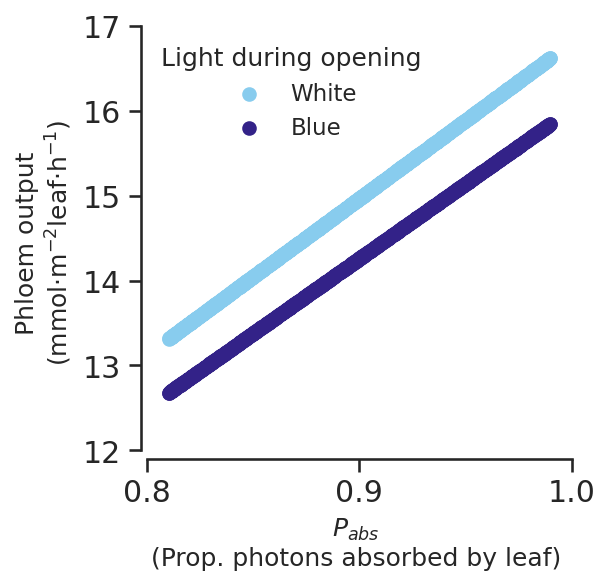

In [27]:
def phloemoutput_subfig(ax):
    for light, colour in zip(
        ["white", "blue"], [sns.color_palette()[1], sns.color_palette()[0]]
    ):
        constraints_light_df = scan_constraints[scan_constraints.light == light]
        results_light_df = scan_results[scan_constraints.light == light]

        ax.scatter(
            constraints_light_df.P_abs,
            results_light_df.Phloem_tx_overall,
            label=light.capitalize(),
            color=colour,
        )

    ax.legend(title="Light during opening", loc="upper left")  # Set loc to "upper left"
    ax.set_xlabel("$P_{abs}$\n(Prop. photons absorbed by leaf)", size="medium")
    ax.set_ylabel(
        "Phloem output\n(mmol$\cdot$m$^{-2}$leaf$\cdot$h$^{-1}$)", size="medium"
    )

    ax.set_ylim(11.9, 17)
    ax.set_xlim(0.797, 1)
    ax.spines["left"].set_bounds(12, 17)
    ax.spines["bottom"].set_bounds(0.8, 1)
    ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    # ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_aspect(abs(1 - 0.8) / abs(17 - 12))

    return ax


fig, ax = plt.subplots()
phloemoutput_subfig(ax)

## 7b - What affects hexose export from the guard cell?

### Generate hexose export df

In [28]:
four_stage_GC_model = cobra.io.sbml.read_sbml_model(
    "../models/4_stage_GC.xml"
)  # read model

# get total flux across all phases
net_carbon_dict = {}
for metabolite in ["GLC", "FRU", "SUCROSE"]:
    net_metabolite = 0
    for i, phase_length in enumerate(get_phase_lengths(four_stage_GC_model)):
        phase_number = i + 1
        net_metabolite = (
            net_metabolite
            + scan_results.loc[:, f"{metabolite}_ae_gc_{phase_number}"] * phase_length
        )
    net_carbon_dict[metabolite] = net_metabolite
net_carbon_df = pd.DataFrame.from_dict(net_carbon_dict)

# correct for fact that sucrose is two hexoses
net_carbon = (
    net_carbon_df.GLC + net_carbon_df.FRU + net_carbon_df.SUCROSE * 2
) * -1  # mmol.m2-1
net_carbon = net_carbon * 10**-3  # moles.m2-1
carbon_per_gc = net_carbon / scan_constraints.N_gcs  # moles.gc-1
carbon_per_gc = carbon_per_gc * 10**15  # fmol.gc-1

No objective coefficients in model. Unclear what should be optimized


### Fit model to hexose export

In [29]:
response = carbon_per_gc
for features in [full_features, gc_features]:
    lm_1 = LinearRegression()
    lm_1.fit(features, response)
    pred = lm_1.predict(features)
    print("Mean squared error, MSE = %.2f" % mean_squared_error(response, pred))
    print("Coefficient of determination, r2 = %.2f" % r2_score(response, pred))

Mean squared error, MSE = 400.72
Coefficient of determination, r2 = 0.46
Mean squared error, MSE = 129.47
Coefficient of determination, r2 = 0.83


So hexose export can be better predicted using the gc features compared to all the features. Is this because it's hexose per gc?

In [30]:
response = net_carbon
for features in [full_features, gc_features]:
    lm_1 = LinearRegression()
    lm_1.fit(features, response)
    pred = lm_1.predict(features)
    print("Mean squared error, MSE = %.2f" % mean_squared_error(response, pred))
    print("Coefficient of determination, r2 = %.2f" % r2_score(response, pred))

Mean squared error, MSE = 0.00
Coefficient of determination, r2 = 0.49
Mean squared error, MSE = 0.00
Coefficient of determination, r2 = 1.00


Seems so, as we're confusing things by introducing the N_gcs division into the response

In [31]:
response = net_carbon
lm_1 = LinearRegression()
lm_1.fit(gc_features, response)
pred = lm_1.predict(gc_features)
lm_coefs = pd.DataFrame(lm_1.coef_, index=gc_features.columns).sort_values(by=0)
lm_coefs[abs(lm_coefs.loc[:, 0]) > 0.00001]

,0
V_closed,-0.011508
Os_dif,-0.000041
Os_closed,0.000034
ATPase,0.000141
Photons,0.000236
V_open,0.004360


Mainly different light colours as well as osmolarity. What if we correct for light colour?

### Create a reponse for total photons into the GC, irrespective of blue or white light

In [32]:
photon_influx = scan_results.loc[:, "Photon_tx_gc_3"]
photon_hours = scan_constraints.loc[:, "light"].apply(
    lambda x: 12 if x == "white" else 11.5
)
total_photons_per_day = photon_influx * photon_hours

In [33]:
response = net_carbon
features = np.array([total_photons_per_day]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["Photons per day"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.947642


,0
Photons per day,0.000019


In [34]:
response = net_carbon
features = np.array([total_photons_per_day, gc_features.Os_dif]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["Photons per day", "Os dif"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.997795


,0
Os dif,-0.000042
Photons per day,0.000020


Pretty good R2

In [35]:
response = net_carbon
features = np.array(gc_features.ATPase).reshape(-1, 1)
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
pd.DataFrame(lm_1.coef_, index=["ATPase"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.044712


,0
ATPase,0.00106


ATPase can't really predict hexose export, at least not by itself

<Axes: xlabel='Photons per day into GC\n(mmol$\\cdot$m$^{-2}\\cdot$d$^{-1}$)', ylabel='Net hexose export flux from GC\n(mmol$\\cdot$m$^{-2}\\cdot$h$^{-1}$)'>

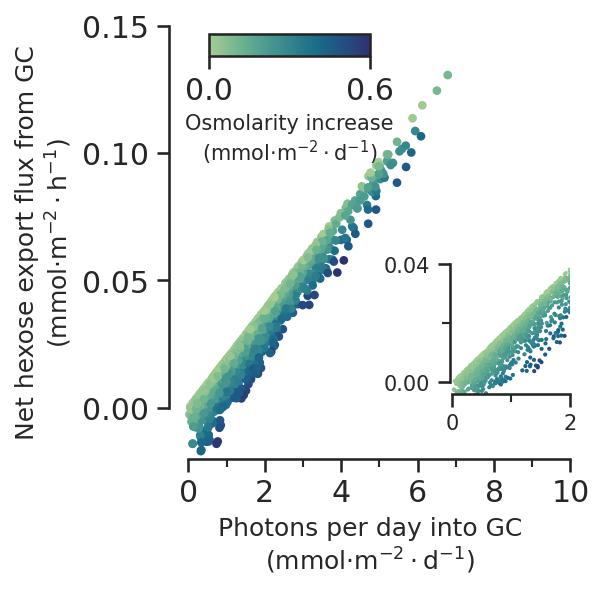

In [36]:
def photons_vs_carbon_export_subfig(ax):
    max_os_dif = scan_gc_constraints.Os_dif.max().round(1)
    norm = Normalize(vmin=0, vmax=max_os_dif)
    mappable = ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))

    net_carbon_mmol = net_carbon * 10**3

    ax.scatter(
        total_photons_per_day,
        net_carbon_mmol,
        c=scan_gc_constraints.Os_dif,
        norm=norm,
        s=10,
        cmap=sns.color_palette("crest", as_cmap=True),
    )

    cbaxes = ax.inset_axes([0.1, 0.93, 0.40, 0.05])
    cbar = plt.colorbar(
        mappable, cax=cbaxes, ticks=[0, max_os_dif], orientation="horizontal"
    )
    cbar.set_label("Osmolarity increase\n(mmol$\cdot$m$^{-2}\cdot$d$^{-1}$)", size=10)

    inset_ax = ax.inset_axes([0.7, 0.15, 0.3, 0.3])
    inset_ax.scatter(
        total_photons_per_day,
        net_carbon_mmol,
        c=scan_gc_constraints.Os_dif,
        s=1,
        cmap=sns.color_palette("crest", as_cmap=True),
    )
    inset_ax.set_xlim([-0.3 / 10, 2])
    inset_ax.set_ylim([-0.02 / 5, 0.04])
    inset_ax.tick_params(labelsize=10)
    inset_ax.spines["left"].set_bounds(0, 0.04)
    inset_ax.spines["bottom"].set_bounds(0, 2)
    inset_ax.yaxis.set_major_locator(MultipleLocator(0.04))
    inset_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    inset_ax.xaxis.set_major_locator(MultipleLocator(2))
    inset_ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    ax.set_xlim([-0.5, 10])
    ax.set_ylim([-0.02, 0.15])
    ax.spines["left"].set_bounds(0, 0.15)
    ax.spines["bottom"].set_bounds(0, 10)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.set_aspect(abs(10 - 0) / abs(0.15 - 0))

    ax.set_xlabel(
        "Photons per day into GC\n" + r"(mmol$\cdot$m$^{-2}\cdot$d$^{-1}$)",
        size="medium",
    )
    ax.set_ylabel(
        "Net hexose export flux from GC\n" + r"(mmol$\cdot$m$^{-2}\cdot$h$^{-1}$)",
        size="medium",
    )

    return ax


fig, ax = plt.subplots()
photons_vs_carbon_export_subfig(ax)

### Are there any solutions that are below 0?

In [37]:
(net_carbon < 0).sum()

151

In [38]:
(net_carbon > 0).sum()

1778

In [39]:
(net_carbon == 0).sum()

0

In [40]:
1-((net_carbon < 0).sum())/len(net_carbon)

0.9217210990150337

What's interesting about them?

In [41]:
scan_constraints.loc[net_carbon < 0]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
12,0.901658,0.000211,1.0,5.425523e-13,0.860942,0.111833,0.206274,0.356898,0.149052,0.809939,...,9.604059e+08,1.759112,0.817956,7.157105e-14,2.865635e-13,0.027052,3.730381,11.572208,8.381496,white
23,0.885284,0.000207,1.0,3.265808e-12,0.790062,0.042741,0.199637,0.185121,0.136024,0.861185,...,9.573261e+08,1.512963,0.961815,7.737083e-14,1.026590e-13,0.036735,2.520634,11.477644,15.823057,white
24,0.824056,0.000196,1.0,8.316548e-13,0.857979,0.092520,0.201655,0.251924,0.209365,0.894181,...,6.482612e+08,1.624520,0.827449,6.230748e-14,2.155940e-13,0.030813,3.649531,11.058935,3.256601,white
39,0.892136,0.000217,1.0,5.191859e-13,0.885713,0.099432,0.191094,0.268568,0.141023,0.796091,...,5.250444e+08,2.048825,0.810788,5.594691e-14,2.095763e-13,0.024651,3.001835,9.722838,13.495194,white
42,0.903741,0.000224,1.0,2.269691e-12,0.833925,0.035884,0.193705,0.229202,0.121804,0.870606,...,1.092058e+09,1.700179,0.858796,5.745681e-14,2.152994e-13,0.032042,1.904180,11.631872,2.074217,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,0.846939,0.000215,1.0,9.631934e-13,0.793669,0.043463,0.206863,0.327413,0.239527,0.815951,...,6.225848e+08,2.087581,0.870089,5.611294e-14,2.106040e-13,0.026592,1.537715,6.625307,2.184347,blue
1871,0.890207,0.000218,1.0,9.456020e-13,0.790219,0.087099,0.192226,0.241455,0.183255,0.880867,...,3.160635e+08,2.460483,0.887517,6.241327e-14,1.193854e-13,0.036092,2.109551,11.228097,8.232004,blue
1883,0.819478,0.000173,1.0,5.789127e-13,0.829855,0.043807,0.193602,0.203906,0.207239,0.769684,...,6.811536e+08,2.298086,0.816187,5.914695e-14,2.871217e-13,0.036605,2.081903,9.401322,14.509810,blue
1909,0.840185,0.000225,1.0,1.781198e-12,0.827474,0.066766,0.198463,0.308428,0.212572,0.784071,...,2.724282e+08,2.248678,0.846613,7.740246e-14,1.652795e-13,0.023135,3.115666,10.692330,10.270917,blue


In [42]:
scan_gc_constraints.loc[net_carbon < 0]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
12,0.000532,0.001071,0.120724,0.528694,0.043583,0.008050,0.407970
23,0.000285,0.000948,0.057752,0.536505,0.069166,0.015148,0.478753
24,0.000287,0.000586,0.064804,0.283186,0.033123,0.002111,0.218382
39,0.000198,0.000396,0.041256,0.170599,0.016240,0.007086,0.129343
42,0.000355,0.000965,0.062158,0.515366,0.046247,0.002265,0.453208
...,...,...,...,...,...,...,...
1868,0.000185,0.000363,0.031127,0.127499,0.017760,0.001360,0.096372
1871,0.000079,0.000259,0.017632,0.147725,0.014065,0.002602,0.130092
1883,0.000279,0.000574,0.057745,0.264626,0.011253,0.009883,0.206881
1909,0.000111,0.000270,0.025527,0.136007,0.019733,0.002798,0.110480


Ok they are the same just with different light colours. Is it the photon/od_dif ratio?

In [43]:
scan_gc_constraints.loc[180, "Photons"] / scan_gc_constraints.loc[180, "Os_dif"]

0.3531575906147493

In [44]:
(scan_gc_constraints.loc[:, "Photons"] / scan_gc_constraints.loc[:, "Os_dif"]).min()

0.03470750449622308

Yes, it has the lowest photon:od_diff ratio of any combination

## At our predicted level of osmolarity and other guard cell parameters, what would FqFm.R_ch need to be for guard cell to act as a sink?

$e = FqFm \cdot R_{ch} \cdot R_{ch_{vol}}$ <- We want to know e, that is the capacity of guard cell vs mesophyll. Function of efficiency, number of chloroplasts, and valume of chloroplasts

$P_{gc} = e \cdot v\_prop_{gc} \cdot P$

$e = \frac{P_{gc}}{v\_prop_{gc} \cdot P}$

In [45]:
P = 150 * paper_constraints.P_abs
P = P * 10**-3 * 60 * 60  # umolessec-1 -> mmolhr-1

In [46]:
V_l = (
    paper_constraints.T_l * paper_constraints.A_l
)  # volume of leaf is area x thickness
V_l = V_l * 10**3  # (Total leaf volume) m3 -> dm3 = 10**3

V_gc = (
    paper_constraints.V_gc_ind * paper_constraints.N_gcs
)  # total volume of gc in leaf

# volume of meosphyll is leaf that isn't epidermis or air
V_me = V_l * (1 - paper_constraints.L_epidermis) * (1 - paper_constraints.L_air)

v_prop_gc = V_gc / V_me  # volume of gc is negligable

In [47]:
response = net_carbon
features = np.array([total_photons_per_day, gc_features.Os_dif]).T
lm_1 = LinearRegression()
lm_1.fit(features, response)
pred = lm_1.predict(features)
print("Mean squared error, MSE = %.6f" % mean_squared_error(response, pred))
print("Coefficient of determination, r2 = %.6f" % r2_score(response, pred))
print(f"Intercept: {lm_1.intercept_}")
pd.DataFrame(lm_1.coef_, index=["Photons per day", "Os dif"]).sort_values(by=0)

Mean squared error, MSE = 0.000000
Coefficient of determination, r2 = 0.997795
Intercept: -2.2684474456014436e-07


,0
Os dif,-0.000042
Photons per day,0.000020


$ C_{net} = -3\cdot10^{-5}\cdot Os_{dif} + 2\cdot10^{-5}\cdot P_{day} - 6.80 \cdot10^{-8}$

$ 0 = -3\cdot10^{-5}\cdot 0.016 + 2\cdot10^{-5}\cdot P_{day} - 6.80 \cdot10^{-8}$

$ \frac{6.80 \cdot10^{-8}  + -3\cdot10^{-5}\cdot 0.016}{2\cdot10^{-5}} = P_{day}$

In [48]:
os_dif_coef = lm_1.coef_[1]
photons_per_day_coef = lm_1.coef_[0]
os_in_selected_scenarios = paper_gc_constraints.Os_dif
intercept = lm_1.intercept_

In [49]:
photons_needed = (
    intercept - os_dif_coef * os_in_selected_scenarios
) / photons_per_day_coef
photons_needed

0.021287136418141717

In [50]:
total_photons_per_day.min() / photons_needed

1.6058048329073886

So at that osmolarity for the guard cell to act as sink tissue the total level of photons coming in would have to be 15x lower than we see in any of our scenarios, which will be for blue light

In [51]:
photon_influx = photons_needed / 11.5

$e = \frac{P_{gc}}{v\_prop_{gc} \cdot P}$

In [52]:
e = photon_influx / (v_prop_gc * P)
e * 100

0.1258548415087798

So the capacity for photosynthesis in the guard cell only needs to be 0.1% of that of the mesophyll to act as a source tissue

### What is the range of photosynthetic capacities that we use?

In [53]:
capacity_percentages = (scan_constraints.FqFm * scan_constraints.R_ch) * 100
print(f"High: {capacity_percentages.max()}")
print(f"Low: {capacity_percentages.min()}")

High: 15.993692749570307
Low: 2.7778959631593407


## 7c - So does the ATPase have an effect on starch if not on hexose export very much?

### How many solutions utilise starch?

In [54]:
starch = scan_results.STARCH_p_gc_Linker_1 - scan_results.STARCH_p_gc_Linker_2
print(f"{(starch > 0).sum()} or {(starch > 0).sum()/len(starch) * 100:.0f}%")

1869 or 97%


## In how many of those solutions is the ATPase constrained?

In [55]:
atpase_constrained = (
    abs(scan_gc_constraints.ATPase - scan_results.PROTON_ATPase_c_gc_2) < 0.000001
)
(atpase_constrained & starch > 0).sum()

1869

In [56]:
((scan_gc_constraints.ATPase - scan_results.PROTON_ATPase_c_gc_2) < 0.000001).sum()

1870

In [57]:
(starch <= 0).sum()

60

In [58]:
scan_gc_constraints[(atpase_constrained & (starch == 0))]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
1779,0.000209,0.000212,0.052828,0.054747,0.188758,0.00101,0.001919


So there is one solution which doesn't

In [59]:
scan_gc_constraints[(atpase_constrained & starch < 0)]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif


In [60]:
(scan_gc_constraints.loc[1685] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

V_closed    -1.088500
V_open      -0.729908
Os_closed   -0.955383
Os_open     -0.433399
Photons     -0.626899
ATPase      -1.026613
Os_dif      -0.245978
dtype: float64

High photons, high ATPase, low osmolarity dif

## How many constrained solutions don't use starch?

In [61]:
(atpase_constrained & (starch == 0)).sum()

1

In [62]:
scan_gc_constraints[(atpase_constrained & (starch == 0))]

,V_closed,V_open,Os_closed,Os_open,Photons,ATPase,Os_dif
1779,0.000209,0.000212,0.052828,0.054747,0.188758,0.00101,0.001919


In [63]:
(scan_gc_constraints.loc[1779] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

V_closed    -0.255103
V_open      -1.026966
Os_closed    0.069561
Os_open     -1.050173
Photons      0.787979
ATPase      -1.100440
Os_dif      -1.182273
dtype: float64

Osmolarity difference is low, photons are high, atpase is low. Closed osmolarity is high, forcing the use of something else?

Increase per GC allows comparison with literature values

In [64]:
starch_per_gc = starch * 10**-3 / scan_constraints.N_gcs * 10**15  # fmol.gc-1

In [65]:
horrer_starch_level = 184

In [66]:
os_increase_per_gc = (
    scan_gc_constraints.Os_dif * 10**-3 / scan_constraints.N_gcs * 10**15
)
protons_moved_per_gc = (
    scan_results.PROTON_ATPase_c_gc_2 * 10**-3 / scan_constraints.N_gcs * 10**15
)

In [67]:
protons_moved_per_gc.max()

16.98638855504794

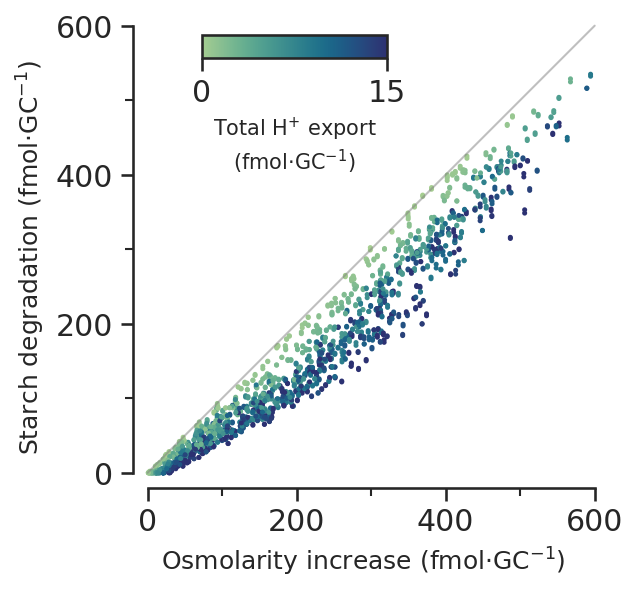

In [125]:
def starch_vs_os_subfig(ax):
    dot_size = 2

    norm = Normalize(vmin=0, vmax=15)
    mappable = ScalarMappable(norm=norm, cmap=sns.color_palette("crest", as_cmap=True))

    ax.plot([0, 600], [0, 600], c="grey", alpha=0.5, clip_on=False, linewidth=1)

    sc = ax.scatter(
        os_increase_per_gc,
        starch_per_gc,
        s=dot_size,
        c=protons_moved_per_gc,
        norm=norm,
        cmap=sns.color_palette("crest", as_cmap=True),
    )

    cbaxes = ax.inset_axes([0.15, 0.93, 0.40, 0.05])
    cbar = plt.colorbar(mappable, cax=cbaxes, ticks=[0, 15], orientation="horizontal")
    cbar.set_label("Total H$^{+}$ export\n(fmol$\cdot$GC$^{-1}$)", size=10)

    y_max = 600
    y_min = -20
    x_max = 600
    x_min = -20
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(200))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(200))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect(1)

    ax.set_xlabel("Osmolarity increase (fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel(r"Starch degradation (fmol$\cdot$GC$^{-1}$)", size="medium")
    # ax.hlines(-155, xmin=0.15, xmax=0.99, clip_on=False, linewidth=1, color='.15')

#     ax.hlines(
#         184,
#         xmin=0,
#         xmax=x_max,
#         linewidth=1,
#         linestyle="--",
#         color=sns.color_palette()[6],
#     )
#     ax.text(
#         x_max,
#         175,
#         "Horrer et al. (2016)",
#         ha="right",
#         va="top",
#         size="x-small",
#         color=sns.color_palette()[6],
#     )

#     paper_scenarios_colour = sns.color_palette()[2]
#     ax.vlines(
#         26.83,
#         ymin=0,
#         ymax=110,
#         linewidth=1,
#         linestyle="--",
#         color=paper_scenarios_colour,
#     )
#     ax.text(
#         50,
#         120,
#         "Paper\nscenarios",
#         ha="center",
#         va="bottom",
#         size="x-small",
#         color=paper_scenarios_colour,
#     )

    return ax


fig, ax = plt.subplots(figsize=(6, 4))

starch_vs_os_subfig(ax)

fig.savefig("../outputs/constraint_scan/atpase_vs_starch.svg")
fig.savefig("../outputs/constraint_scan/atpase_vs_starch.png")

### How do starch levels vary with white/blue light?

In [69]:
starch_per_gc

0        58.385114
1       288.556232
2        86.609569
3        27.002534
4       266.548424
           ...    
1925    327.805590
1926    192.894997
1927    397.936464
1928    254.681856
1929     81.143024
Length: 1929, dtype: float64

## How is starch used?

What proportion of white light solutions that degrade starch use it for osmoticum?

In [70]:
(
    (
        (scan_constraints["light"] == "white")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "white") & (starch > 0)).sum() * 100

100.0

What proportion of white light solutions that degrade starch use it for energy?

In [71]:
(
    (
        (scan_constraints["light"] == "white")
        & (starch > 0)
        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "white") & (starch > 0)).sum() * 100

37.29903536977492

In the solutions that use it for energy, what is the average % used for energy?

In [72]:
(
    (
        (
            scan_results[
                (
                    (
                        (scan_constraints["light"] == "white")
                        & (starch > 0)
                        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
                    )
                )
            ].MALTODEG_RXN_c_gc_2
        )
        / starch[
            (
                (scan_constraints["light"] == "white")
                & (starch > 0)
                & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
            )
        ]
    )
    * 100
).mean()

3.417354320693738

What proportion of blue light solutions that degrade starch use it for osmoticum?

In [73]:
(
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "blue") & (starch > 0)).sum() * 100

99.8931623931624

In [74]:
((scan_constraints["light"] == "blue") & (starch > 0)).sum() - (
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.RXN_2141_p_gc_2 > 0)
    ).sum()
)

1

Only one solution doesn't

In [75]:
scan_constraints[
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & ~(scan_results.RXN_2141_p_gc_2 > 0)
    )
]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
1640,0.964602,0.000176,1.0,3.434140e-12,0.878235,0.054747,0.212043,0.212421,0.122047,0.879218,...,4.925898e+08,2.170346,0.884783,7.164384e-14,1.293008e-13,0.030355,3.377155,4.285834,15.108044,blue


#### 1640 is solution without constrained ATPase

What proportion of blue light solutions that degrade starch use it for energy?

In [76]:
(
    (
        (scan_constraints["light"] == "blue")
        & (starch > 0)
        & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ).sum()
) / ((scan_constraints["light"] == "blue") & (starch > 0)).sum() * 100

98.3974358974359

In [77]:
(
    (scan_constraints["light"] == "blue")
    & (starch > 0)
    & ~(scan_results.MALTODEG_RXN_c_gc_2 > 0)
).sum()

15

25 solutions that use starch in blue light don't use the energy pathway

In [78]:
(
    (
        (
            scan_results[
                (
                    (scan_constraints["light"] == "blue")
                    & (starch > 0)
                    & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
                )
            ].MALTODEG_RXN_c_gc_2
        )
        / starch[
            (
                (scan_constraints["light"] == "blue")
                & (starch > 0)
                & (scan_results.MALTODEG_RXN_c_gc_2 > 0)
            )
        ]
    )
    * 100
).mean()

6.919264127838729

Average of 5% of starch degraded was used for energy

## 7d - How does glucose increase during opening vary with starch, and why isn't it totally linear?

Is sucrose degaded in the cytoplasm in any solutions?

In [79]:
(scan_results[starch > 0]["RXN_1461_c_gc_2"] > 0).sum()

1

No

In [80]:
sucrose_degraded_v = scan_results[starch > 0]["RXN_1461_v_gc_2"] > 0.000001
no_sucrose_degraded_v = scan_results[starch > 0]["RXN_1461_v_gc_2"] < 0.000001
glucose_import_into_vacuole = (
    scan_results[starch > 0]["GLC_PROTON_rev_cv_gc_2"] > 0.000001
)
no_glucose_import_into_vacuole = (
    scan_results[starch > 0]["GLC_PROTON_rev_cv_gc_2"] < 0.000001
)

In [81]:
sucrose_deg_and_glc_import = sucrose_degraded_v & glucose_import_into_vacuole
sucrose_deg_no_glc_import = sucrose_degraded_v & no_glucose_import_into_vacuole
no_sucrose_deg_glc_import = no_sucrose_degraded_v & glucose_import_into_vacuole
no_sucrose_deg_no_glc_import = no_sucrose_degraded_v & no_glucose_import_into_vacuole

In [82]:
conditions = [
    sucrose_deg_and_glc_import,
    sucrose_deg_no_glc_import,
    no_sucrose_deg_glc_import,
    no_sucrose_deg_no_glc_import,
]
labels = ["+ S.d. + G.i.", "+ S.d - G.i.", "- S.d + G.i.", "- S.d - G.i."]

In [83]:
for condition, label in zip(conditions, labels):
    print(f"{label}:")
    print(
        f"Length: {(condition).sum()} ({((condition).sum()/len(scan_constraints[starch > 0]) * 100).round(1)}%)"
    )
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).median()
    print(f"Starch median % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).mean()
    print(f"Starch mean % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).max()
    print(f"Starch max % of osmolarity: {starch_proportion}")
    starch_proportion = (
        (
            scan_results[starch > 0][condition].STARCH_p_gc_Linker_1
            / scan_gc_constraints.loc[starch > 0][condition].Os_dif
        )
        * 100
    ).min()
    print(f"Starch min % of osmolarity: {starch_proportion}")

+ S.d. + G.i.:
Length: 1726 (92.3%)
Starch median % of osmolarity: 70.14328225791937
Starch mean % of osmolarity: 70.00709468647005
Starch max % of osmolarity: 101.09841873149792
Starch min % of osmolarity: 26.601500015072844
+ S.d - G.i.:
Length: 73 (3.9%)
Starch median % of osmolarity: 37.24857214274382
Starch mean % of osmolarity: 39.56843861627318
Starch max % of osmolarity: 98.83574552896556
Starch min % of osmolarity: 17.957273032147842
- S.d + G.i.:
Length: 5 (0.3%)
Starch median % of osmolarity: 85.96913138539946
Starch mean % of osmolarity: 79.33698865115343
Starch max % of osmolarity: 100.0345395864072
Starch min % of osmolarity: 48.205900111927264
- S.d - G.i.:
Length: 65 (3.5%)
Starch median % of osmolarity: 28.718985555545924
Starch mean % of osmolarity: 33.98609969901858
Starch max % of osmolarity: 98.05123077529065
Starch min % of osmolarity: 0.5779276291728861


In [84]:
glc_increase = (
    scan_results[starch > 0].GLC_total_pseudolinker_2
    - scan_results[starch > 0].GLC_total_pseudolinker_1
)
glc_increase_per_gc = glc_increase * 10**-3 / scan_constraints.N_gcs * 10**15

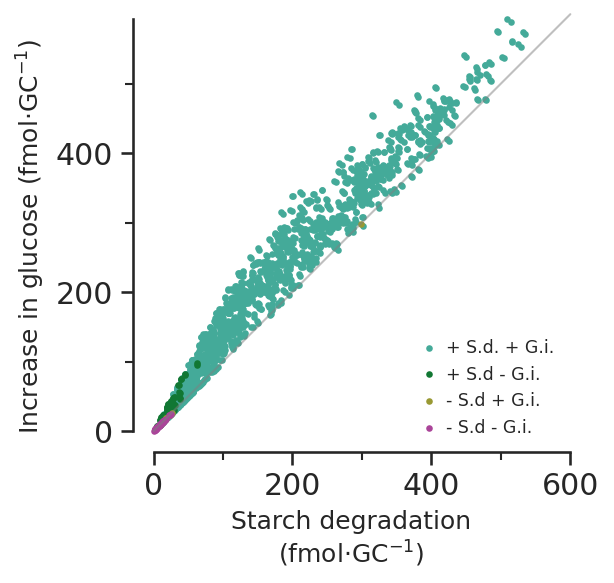

In [85]:
def glucose_vs_starch_subfig(ax):
    x = [0, 600]
    y = [0, 600]

    size = 10

    ax.plot(x, y, c="grey", alpha=0.5, clip_on=False, linewidth=1)

    conditions = [
        sucrose_deg_and_glc_import,
        sucrose_deg_no_glc_import,
        no_sucrose_deg_glc_import,
        no_sucrose_deg_no_glc_import,
    ]
    colours = [
        sns.color_palette()[2],
        sns.color_palette()[3],
        sns.color_palette()[4],
        sns.color_palette()[8],
    ]
    labels = ["+ S.d. + G.i.", "+ S.d - G.i.", "- S.d + G.i.", "- S.d - G.i."]

    glucose_increase_max = glc_increase_per_gc.max()

    for condition, colour, label in zip(conditions, colours, labels):
        ax.scatter(
            starch_per_gc[starch > 0][condition],
            glc_increase_per_gc[starch > 0][condition],
            color=colour,
            s=size,
            label=label,
            linewidths=0,
            clip_on=False,
        )

    ax.set_xlabel("Starch degradation\n" r"(fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel("Increase in glucose (fmol$\cdot$GC$^{-1}$)", size="medium")

    y_max = glucose_increase_max
    x_max = 600
    major_increment = 200
    ax.set_ylim(None, y_max)
    ax.set_xlim(None, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(major_increment))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(major_increment))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect("equal")

#     ax.vlines(
#         184, ymin=0, ymax=570, linewidth=1, linestyle="--", color=sns.color_palette()[6]
#     )
#     ax.text(
#         184,
#         570,
#         "Horrer et al. (2016)",
#         ha="center",
#         va="bottom",
#         size="x-small",
#         color=sns.color_palette()[6],
#     )

    ax.legend(
        loc="lower right", bbox_to_anchor=(1, 0), handletextpad=0, fontsize="x-small"
    )

    return ax


fig, ax = plt.subplots()

glucose_vs_starch_subfig(ax)

fig.savefig("../outputs/constraint_scan/starch_vs_glucose.svg")
fig.savefig("../outputs/constraint_scan/starch_vs_glucose.png", dpi=300)

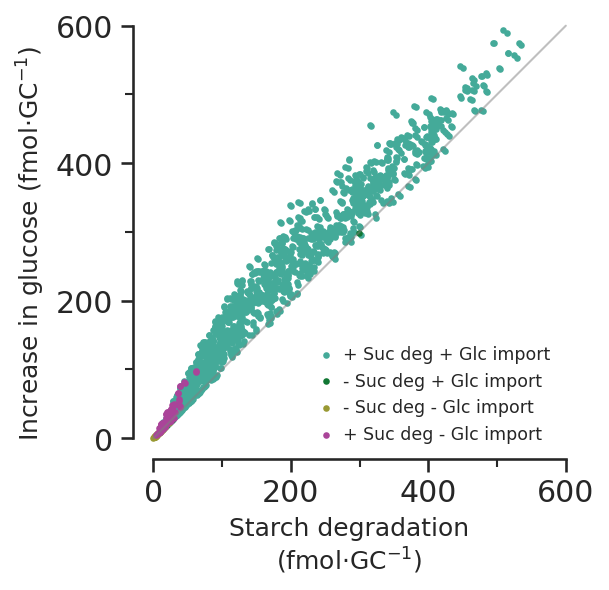

In [86]:
def glucose_vs_starch_subfig(ax):
    x = [0, 600]
    y = [0, 600]

    size = 10

    ax.plot(x, y, c="grey", alpha=0.5, clip_on=False, linewidth=1)

    conditions = [
        sucrose_deg_and_glc_import,
        no_sucrose_deg_glc_import,
        no_sucrose_deg_no_glc_import,
        sucrose_deg_no_glc_import,
    ]
    colours = [
        sns.color_palette()[2],
        sns.color_palette()[3],
        sns.color_palette()[4],
        sns.color_palette()[8],
    ]
    labels = ["+ Suc deg + Glc import", "- Suc deg + Glc import", "- Suc deg - Glc import", "+ Suc deg - Glc import"]

    glucose_increase_max = glc_increase_per_gc.max()

    for condition, colour, label in zip(conditions, colours, labels):
        ax.scatter(
            starch_per_gc[starch > 0][condition],
            glc_increase_per_gc[starch > 0][condition],
            color=colour,
            s=size,
            label=label,
            linewidths=0,
            clip_on=False,
        )

    ax.set_xlabel("Starch degradation\n" r"(fmol$\cdot$GC$^{-1}$)", size="medium")
    ax.set_ylabel("Increase in glucose (fmol$\cdot$GC$^{-1}$)", size="medium")

    #y_max = glucose_increase_max
    y_max = 600
    x_max = 600
    major_increment = 200
    ax.set_ylim(None, y_max)
    ax.set_xlim(None, x_max)
    ax.spines["left"].set_bounds(0, y_max)
    ax.spines["bottom"].set_bounds(0, x_max)
    ax.xaxis.set_major_locator(MultipleLocator(major_increment))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(major_increment))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_aspect("equal")

#     ax.vlines(
#         184, ymin=0, ymax=570, linewidth=1, linestyle="--", color=sns.color_palette()[6]
#     )
#     ax.text(
#         184,
#         570,
#         "Horrer et al. (2016)",
#         ha="center",
#         va="bottom",
#         size="x-small",
#         color=sns.color_palette()[6],
#     )

    ax.legend(
        loc="lower right", bbox_to_anchor=(1, 0), handletextpad=0, fontsize='x-small'
        #prop={'family': 'DejaVu Sans Mono', 'size': 'x-small'},
    )

    return ax


fig, ax = plt.subplots()

glucose_vs_starch_subfig(ax)

fig.savefig("../outputs/constraint_scan/starch_vs_glucose.svg")
fig.savefig("../outputs/constraint_scan/starch_vs_glucose.png", dpi=300)

## Combine subfigures

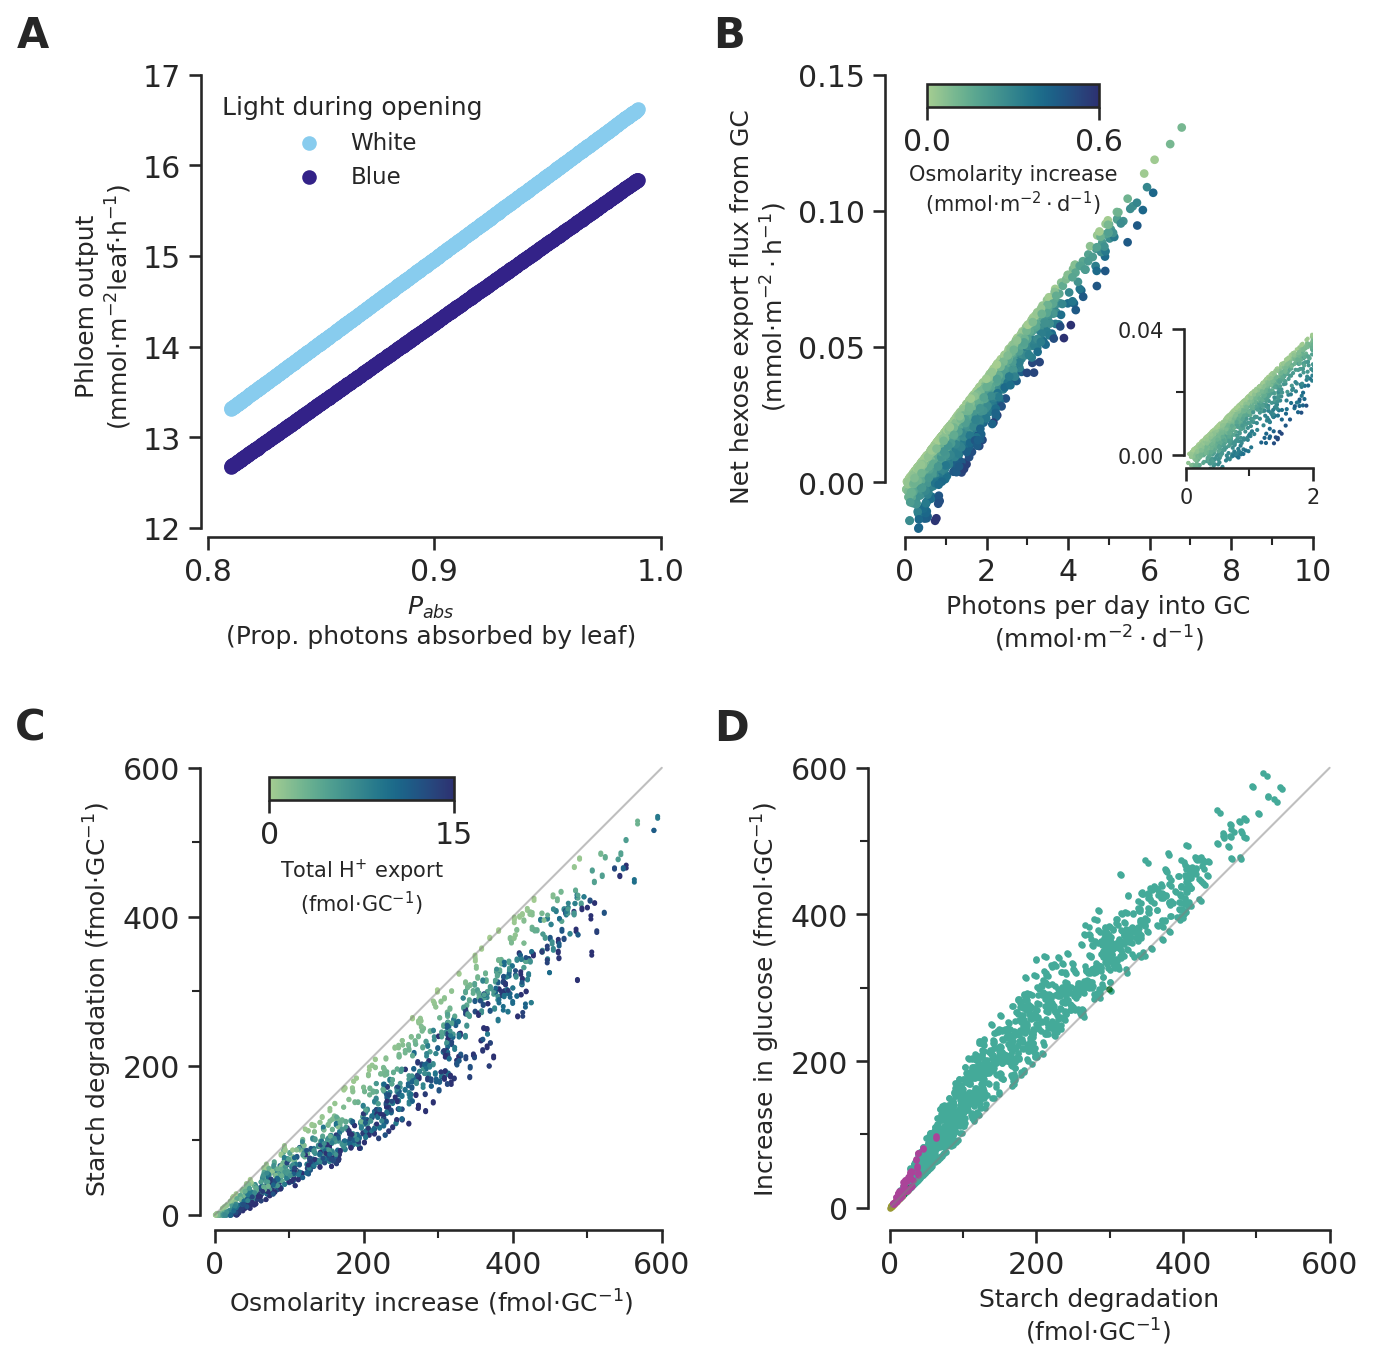

In [126]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.subplots_adjust(hspace=0.5, wspace=0.35)

phloemoutput_subfig(axs[0][0])

photons_vs_carbon_export_subfig(axs[0][1])

starch_vs_os_subfig(axs[1][0])

glucose_vs_starch_subfig(axs[1][1])
axs[1][1].get_legend().remove()

for ax, letter in zip(
    [axs[0][0], axs[0][1], axs[1][0], axs[1][1]], ["A", "B", "C", "D"]
):
    if letter != "D":
        ax.text(-0.4, 1.06, letter, transform=ax.transAxes, size=20, weight="bold")
    else:
        ax.text(-0.333, 1.06, letter, transform=ax.transAxes, size=20, weight="bold")

fig.savefig(
    "../outputs/constraint_scan/constraint_scan_analysis_plot.svg", transparent=True
)
fig.savefig(
    "../outputs/constraint_scan/constraint_scan_analysis_plot.png", transparent=True
)

------------

## Extra analyses not included

### What is the ratio of mitochondrial to plastidic ATP synthase?

Text(0.5, 0, 'Plastidial ATP Synthase\nMitochondrial ATP Synthase')

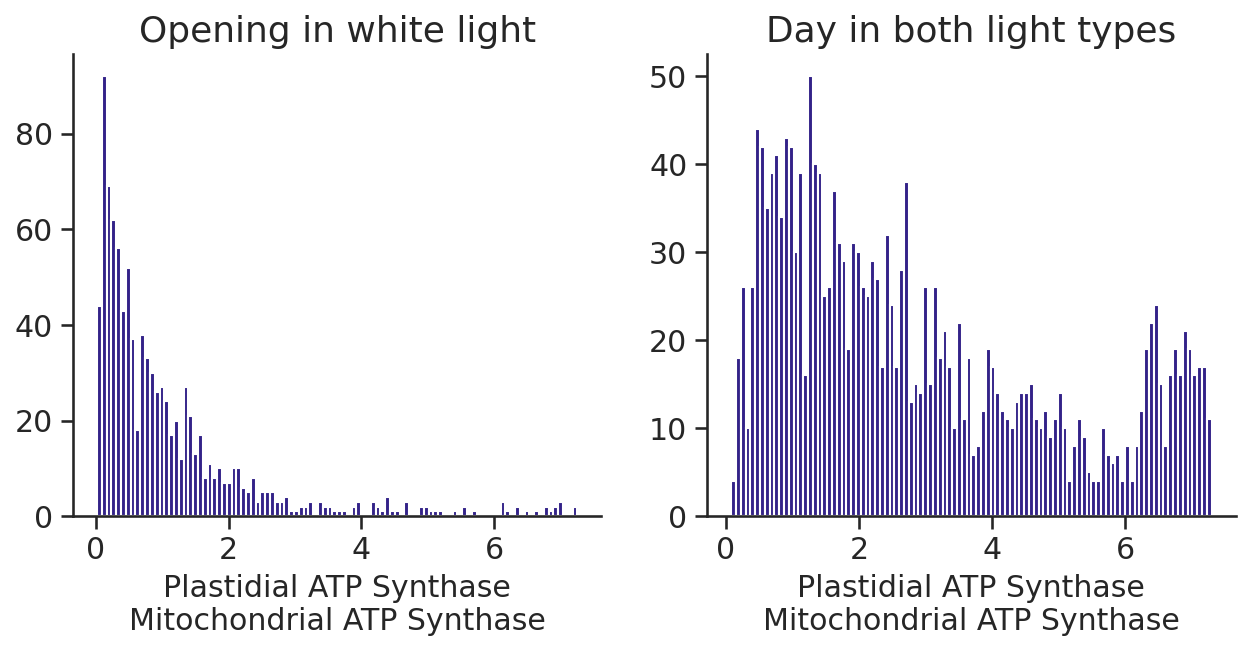

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(
    scan_results.Plastidial_ATP_Synthase_p_gc_2[scan_constraints.light == "white"]
    / scan_results.Mitochondrial_ATP_Synthase_m_gc_2[scan_constraints.light == "white"],
    bins=100,
)
axs[0].set_title("Opening in white light")
axs[0].set_xlabel("Plastidial ATP Synthase\nMitochondrial ATP Synthase")
axs[1].hist(
    scan_results.Plastidial_ATP_Synthase_p_gc_3
    / scan_results.Mitochondrial_ATP_Synthase_m_gc_3,
    bins=100,
)
axs[1].set_title("Day in both light types")
axs[1].set_xlabel("Plastidial ATP Synthase\nMitochondrial ATP Synthase")

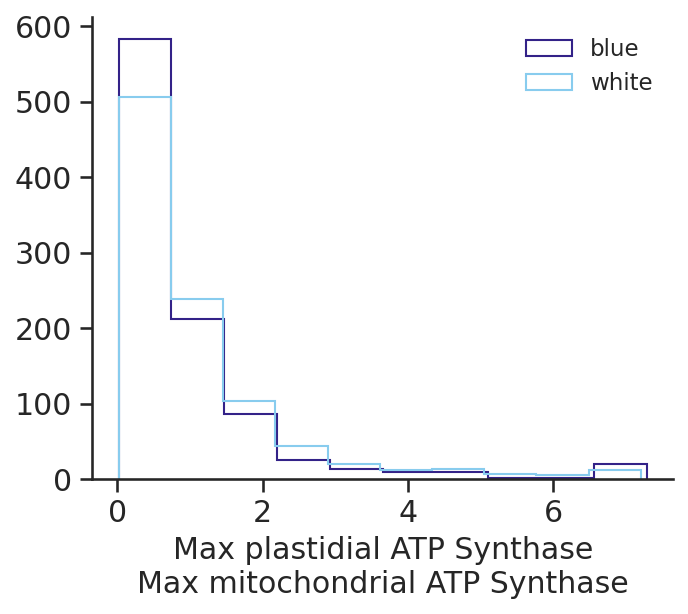

In [89]:
fig, ax = plt.subplots(1, figsize=(5, 4))

plastidial_atp_max = scan_results.loc[
    :, ["Plastidial_ATP_Synthase_p_gc_3", "Plastidial_ATP_Synthase_p_gc_2"]
].max(axis=1)
mitochondial_atp_max = scan_results.loc[
    :, ["Mitochondrial_ATP_Synthase_m_gc_3", "Mitochondrial_ATP_Synthase_m_gc_2"]
].max(axis=1)

for light in ["blue", "white"]:
    ax.hist(
        plastidial_atp_max[scan_constraints.light == light]
        / mitochondial_atp_max[scan_constraints.light == light],
        histtype="step",
        label=light,
    )

ax.set_xlabel("Max plastidial ATP Synthase\nMax mitochondrial ATP Synthase")

ax.legend()

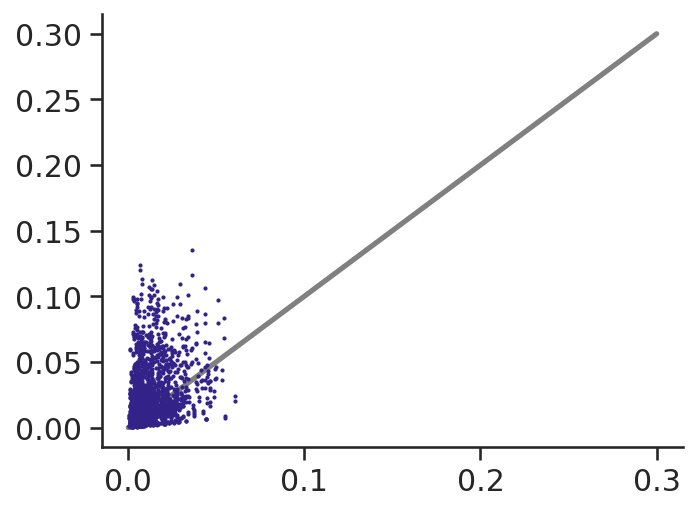

In [90]:
fig, ax = plt.subplots()

ax.plot([0, 0.3], [0, 0.3], c="grey", zorder=0)
ax.scatter(plastidial_atp_max, mitochondial_atp_max, s=1)

In [91]:
(plastidial_atp_max / mitochondial_atp_max).min()

0.0173466271063386

## Almost all starch is used for glucose, and PEP carboxykinase reaction never runs

In [92]:
(scan_results.PEPCARBOX_RXN_c_gc_2 > 0).sum()

68

In [93]:
(scan_results.PEPDEPHOS_RXN_c_gc_2 > 0).sum()

1242

In [94]:
((scan_results.MALTODEG_RXN_c_gc_2 > 0) & (scan_results.PEPDEPHOS_RXN_c_gc_2 > 0)).sum()

1232

In [95]:
((scan_results.MALTODEG_RXN_c_gc_2 > 0) & (scan_results.PYRUVDEH_RXN_m_gc_2 > 0)).sum()

1232

In [96]:
(
    (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    & (scan_results.ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2 > 0)
).sum()

1268

<Axes: >

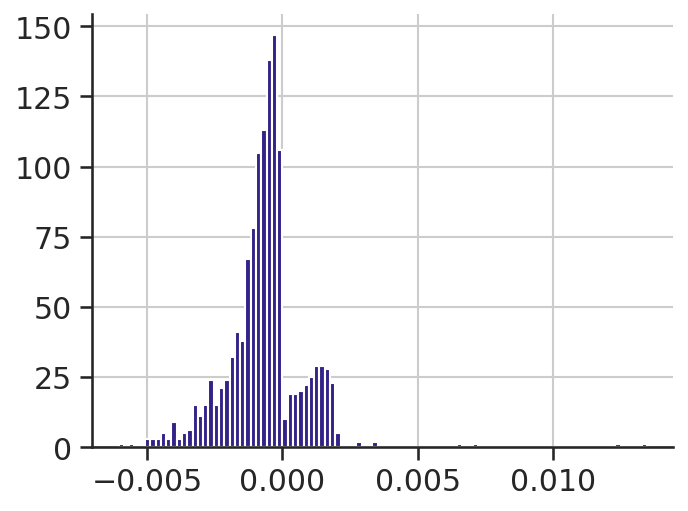

In [97]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2 / 2
    - scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].PEPDEPHOS_RXN_c_gc_2
).hist(bins=100)

<Axes: >

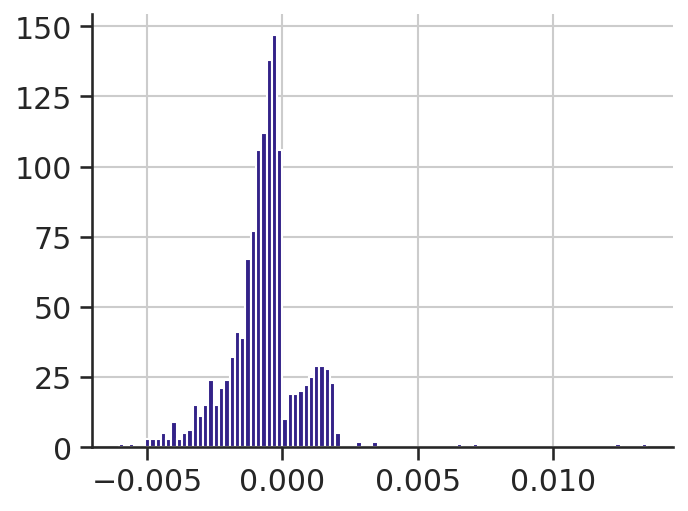

In [98]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2 / 2
    - scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].PYRUVDEH_RXN_m_gc_2
).hist(bins=100)

In [99]:
(
    scan_results[(scan_results.MALTODEG_RXN_c_gc_2 > 0)].MALTODEG_RXN_c_gc_2
    - scan_results[
        (scan_results.MALTODEG_RXN_c_gc_2 > 0)
    ].ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2
)

6       0.000066
7       0.005647
8       0.000217
12      0.004203
13      0.000482
          ...   
1925    0.004629
1926    0.001671
1927    0.004493
1928    0.003693
1929    0.000861
Length: 1269, dtype: float64

In [100]:
(scan_results.MAL_total_pseudolinker_2 > 0).sum()

426

In [101]:
scan_constraints[
    (
        (scan_results.MAL_total_pseudolinker_2 - scan_results.MAL_total_pseudolinker_1)
        > 0
    )
]

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
7,0.955690,0.000236,1.0,2.869423e-12,0.828326,0.061666,0.211974,0.190590,0.192294,0.869461,...,8.116433e+08,2.271307,0.856151,5.324417e-14,2.726638e-13,0.026442,1.081581,10.574273,2.971665,white
13,0.985073,0.000208,1.0,3.538940e-12,0.792574,0.071430,0.189903,0.267139,0.207336,0.882266,...,4.919585e+08,1.509469,0.812493,6.007262e-14,2.756543e-13,0.035865,2.832320,9.899333,5.098963,white
14,0.849357,0.000183,1.0,2.288591e-12,0.830021,0.055266,0.208988,0.222957,0.182608,0.842169,...,3.884950e+08,2.008447,0.802659,7.499584e-14,2.881058e-13,0.028817,2.761460,8.742700,1.063100,white
18,0.851497,0.000206,1.0,4.839152e-13,0.822019,0.068504,0.195438,0.325734,0.203715,0.814012,...,7.059447e+08,1.803709,0.831444,5.480091e-14,1.323340e-13,0.036623,1.747063,4.154988,15.150103,white
21,0.915637,0.000222,1.0,3.640429e-12,0.824572,0.109651,0.196674,0.205225,0.145549,0.821049,...,3.026262e+08,2.498878,0.830149,6.439480e-14,2.168816e-13,0.026802,2.270693,11.811559,1.742742,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1884,0.850154,0.000177,1.0,2.368269e-12,0.831297,0.128015,0.201925,0.233542,0.125233,0.771485,...,8.811403e+08,2.065358,0.897188,5.183399e-14,1.511071e-13,0.023895,3.716113,4.310034,6.240799,blue
1886,0.886457,0.000227,1.0,2.936795e-12,0.892503,0.038868,0.204370,0.316714,0.171100,0.807569,...,3.417440e+08,1.825925,0.901413,7.197494e-14,2.150551e-13,0.034229,3.998096,9.820665,1.124581,blue
1891,0.984415,0.000177,1.0,1.981686e-12,0.852620,0.177646,0.195881,0.198800,0.187767,0.805926,...,1.069613e+09,2.079302,0.943807,5.776741e-14,2.123573e-13,0.032658,3.219929,4.414240,12.486336,blue
1892,0.974632,0.000181,1.0,3.782263e-12,0.839363,0.141305,0.197986,0.258899,0.237294,0.879024,...,1.005476e+09,2.431364,0.962727,6.622327e-14,2.810400e-13,0.025190,2.528450,8.069166,6.824443,blue


In [102]:
starch[1384]

0.15941043613946

In [103]:
(scan_constraints.loc[1384] - scan_constraints.mean()) / scan_constraints.std()

/tmp/ipykernel_5735/1811876447.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (scan_constraints.loc[1384] - scan_constraints.mean()) / scan_constraints.std()
/tmp/ipykernel_5735/1811876447.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  (scan_constraints.loc[1384] - scan_constraints.mean()) / scan_constraints.std()


ATPase        -0.895413
A_closed       1.338392
A_l                 NaN
A_open         0.567254
C_apo         -0.004629
FqFm          -0.881837
L_air          1.140859
L_epidermis    -0.92422
N_gcs          0.734105
P_abs         -1.616356
R                   NaN
R_ch           1.060926
R_ch_vol      -1.370937
T             -0.201285
T_l           -0.168542
V_gc_ind      -0.005303
Vac_frac      -1.605804
light               NaN
m              0.716024
n             -1.685232
r             -0.109866
s             -0.716704
dtype: object

In [104]:
scan_constraints.loc[1384].ATPase

4.18980663388766

In [105]:
scan_constraints.mean().ATPase

/tmp/ipykernel_5735/856568451.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  scan_constraints.mean().ATPase


8.57670862767019

In [106]:
atpase_constrained[1384]

True

In [107]:
scan_results.loc[1384].MALTODEG_RXN_c_gc_2 / starch[1384] * 100

6.752139738405499

In [108]:
scan_results.loc[1384].RXN_2141_p_gc_2

0.1486468207337219

In [109]:
scan_results.loc[1384].MALATE_DEH_RXN_m_gc_2

0.0115628678781543

In [110]:
scan_results.loc[1384].ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc_2

0.0057407299766765

In [111]:
(scan_gc_constraints.loc[1384] - scan_gc_constraints.mean()) / scan_gc_constraints.std()

V_closed     0.853551
V_open       0.764293
Os_closed    1.021528
Os_open      0.725509
Photons      0.743519
ATPase      -0.477527
Os_dif       0.553814
dtype: float64

In [112]:
for i in [i+1 for i in range(4)]:
    reaction = f"PALMITATE_c_gc_Linker_{i}"
    print(reaction)
    print(scan_results.loc[:, reaction].sum())

PALMITATE_c_gc_Linker_1
0.0
PALMITATE_c_gc_Linker_2
0.0
PALMITATE_c_gc_Linker_3
0.0
PALMITATE_c_gc_Linker_4
0.0


In [113]:
scan_results.filter(like="ATPase", axis=1)

,PROTON_ATPase_c_me_1,PROTON_ATPase_c_me_2,PROTON_ATPase_c_me_3,PROTON_ATPase_c_me_4,PROTON_ATPase_c_gc_1,PROTON_ATPase_c_gc_2,PROTON_ATPase_c_gc_3,PROTON_ATPase_c_gc_4,ATPase_tx_me_1,ATPase_tx_me_2,ATPase_tx_me_3,ATPase_tx_me_4,ATPase_tx_gc_1,ATPase_tx_gc_2,ATPase_tx_gc_3,ATPase_tx_gc_4
0,1.117024,3.677485,3.786469,1.114195,0.000006,0.002164,0.000395,0.000006,10.025916,12.198755,12.198755,10.025916,0.000444,0.000667,0.000667,0.000444
1,1.299456,4.278088,4.420086,1.296164,0.000025,0.004629,0.004629,0.000025,10.025916,12.514737,12.514737,10.025916,0.000444,0.002494,0.002494,0.000444
2,1.353879,4.457260,4.594636,1.350449,0.000006,0.000851,0.000217,0.000006,10.025916,12.609705,12.609705,10.025916,0.000444,0.002127,0.002127,0.000444
3,1.141354,3.757584,3.869241,1.138463,0.000006,0.005861,0.000042,0.000006,10.025916,12.240865,12.240865,10.025916,0.000444,0.000916,0.000916,0.000444
4,1.273148,4.191476,4.330990,1.269922,0.000025,0.006976,0.006613,0.000025,10.025916,12.469878,12.469878,10.025916,0.000444,0.001510,0.001510,0.000444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,1.284251,3.852753,4.388499,1.281133,0.000025,0.008071,0.007828,0.000025,10.025916,10.025916,12.598669,10.025916,0.000444,0.000444,0.001907,0.000444
1926,1.209326,3.627979,4.118160,1.206390,0.000025,0.003160,0.002466,0.000025,10.025916,10.025916,12.463673,10.025916,0.000444,0.000444,0.000617,0.000444
1927,1.183739,3.551216,4.029739,1.180865,0.000025,0.004860,0.002002,0.000025,10.025916,10.025916,12.417286,10.025916,0.000444,0.000444,0.000623,0.000444
1928,1.116307,3.348922,3.811023,1.113597,0.000025,0.006749,0.005862,0.000025,10.025916,10.025916,12.294034,10.025916,0.000444,0.000444,0.001267,0.000444


In [114]:
scan_constraints

,P_abs,T_l,A_l,V_gc_ind,FqFm,R_ch,R_ch_vol,L_air,L_epidermis,Vac_frac,...,N_gcs,n,m,r,s,C_apo,A_closed,A_open,ATPase,light
0,0.821263,0.000219,1.0,1.985531e-12,0.893439,0.164738,0.211405,0.187493,0.184501,0.895672,...,2.415771e+08,2.491444,0.909122,5.355413e-14,2.296275e-13,0.023939,2.303029,5.442436,8.959799,white
1,0.941372,0.000178,1.0,3.598954e-12,0.898505,0.154986,0.210076,0.348168,0.210304,0.819755,...,7.175430e+08,2.159945,0.881894,6.420317e-14,2.166552e-13,0.025459,3.557535,11.198578,6.451445,white
2,0.977125,0.000173,1.0,2.840697e-12,0.843482,0.169498,0.210506,0.185908,0.143417,0.790013,...,9.187141e+08,2.201635,0.993783,5.726095e-14,1.284962e-13,0.035615,1.607276,4.894487,0.925869,white
3,0.837272,0.000216,1.0,2.785511e-12,0.837985,0.075850,0.212841,0.205723,0.171366,0.774391,...,8.060406e+08,1.886525,0.977332,6.064119e-14,1.612963e-13,0.024588,1.535557,3.282600,7.271118,white
4,0.924047,0.000180,1.0,2.909005e-12,0.810827,0.180420,0.211274,0.332073,0.120961,0.886934,...,5.123453e+08,1.961033,0.928857,5.519750e-14,2.957881e-13,0.035039,3.362713,11.709579,13.615575,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1925,0.972871,0.000190,1.0,3.529601e-12,0.793892,0.152619,0.201732,0.342169,0.225463,0.810636,...,6.381973e+08,2.023977,0.859768,6.331852e-14,1.828241e-13,0.025324,1.923323,11.278919,12.646881,blue
1926,0.921364,0.000193,1.0,1.236011e-12,0.820257,0.111382,0.195551,0.245000,0.131521,0.773102,...,4.069728e+08,2.005273,0.858563,6.292816e-14,2.793057e-13,0.024336,1.779094,8.512509,7.764663,blue
1927,0.903836,0.000188,1.0,2.108894e-12,0.845302,0.058593,0.191685,0.231204,0.115305,0.871670,...,4.768987e+08,1.511255,0.868149,7.080116e-14,2.536254e-13,0.035799,1.224100,10.942325,10.191606,blue
1928,0.857499,0.000226,1.0,2.952694e-12,0.882173,0.170147,0.204187,0.225685,0.166834,0.876019,...,5.833674e+08,1.775285,0.918564,6.716867e-14,1.256718e-13,0.023201,1.599978,9.413543,11.569244,blue


In [115]:
print(min(scan_constraints.P_abs))
print(min(scan_results.Phloem_tx_overall))

0.8101673308967071
12.67468762842029


In [116]:
print(max(scan_constraints.R_ch_vol))
print(min(scan_constraints.R_ch_vol))

0.2128407420359152
0.1889727321710271
